# Desenvolvimento em Keras

Nesse problema de Data Science, o que se quer é criar um modelo que consiga prever a potência gerada instatânea gerada pelo aerogerador através da velocidade e direção do vento.

### 1. Aquisição de dados

In [71]:
# Importando dados
import pandas as pd

filename = 'T1.csv'
df = pd.read_csv(filename)

df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
Date/Time                        50530 non-null object
LV ActivePower (kW)              50530 non-null float64
Wind Speed (m/s)                 50530 non-null float64
Theoretical_Power_Curve (KWh)    50530 non-null float64
Wind Direction (°)               50530 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


Não há presença de objetos nulos

In [73]:
#Passando DateTime para o tipo datetime

df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
Date/Time                        50530 non-null datetime64[ns]
LV ActivePower (kW)              50530 non-null float64
Wind Speed (m/s)                 50530 non-null float64
Theoretical_Power_Curve (KWh)    50530 non-null float64
Wind Direction (°)               50530 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


In [74]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


### 2. Desbravando dados

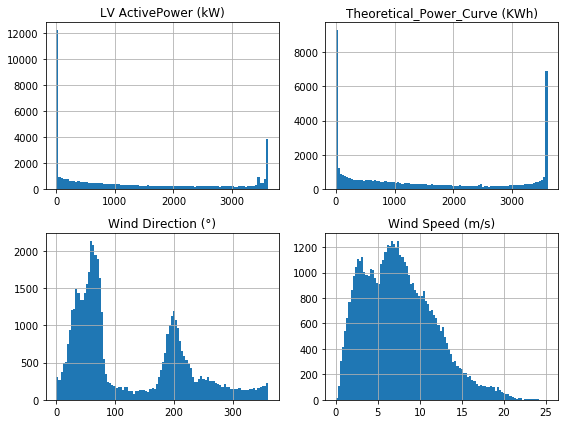

In [75]:
# Plotando histogramas dos dados

import matplotlib.pyplot as plt
%matplotlib inline  
df.hist(bins=100, figsize=(8,6))
plt.tight_layout()
plt.show()

In [76]:
df.corr()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
LV ActivePower (kW),1.000000,0.912774,0.949918,-0.062702
Wind Speed (m/s),0.912774,1.000000,0.944209,-0.077188
Theoretical_Power_Curve (KWh),0.949918,0.944209,1.000000,-0.099076
Wind Direction (°),-0.062702,-0.077188,-0.099076,1.000000


### 3. Preparando os dados para a rede neural

##### 3.1 Remoção de números negativos

In [77]:
for cols in df.columns.tolist()[1:]:
    df = df.loc[df[cols] > 0]

df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,39265.000000,39265.000000,39265.000000,39265.000000
mean,1682.757970,8.835618,1849.600792,115.081817
std,1259.248116,3.740388,1299.455462,86.093682
min,0.028733,3.002270,16.073052,0.015678
25%,504.130402,5.985851,620.233851,48.838100
50%,1421.088989,8.168509,1627.920349,69.959221
75%,2925.330078,11.145490,3321.427096,197.017807
max,3618.732910,25.206011,3600.000000,359.997589


##### 3.2 Remoção de outliers

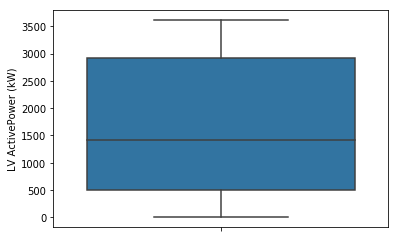

In [78]:
import seaborn as sb

sb.boxplot(data = df, y= 'LV ActivePower (kW)')

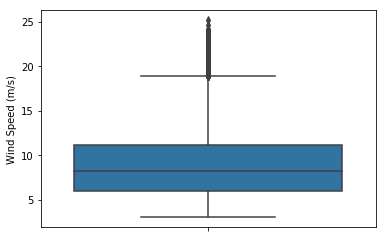

In [79]:
sb.boxplot(data = df, y= 'Wind Speed (m/s)')

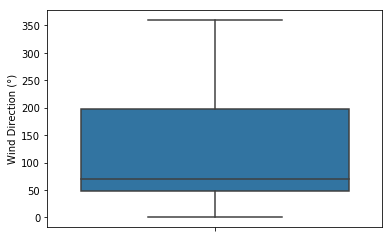

In [80]:
sb.boxplot(data = df, y= 'Wind Direction (°)')

Nota-se, pelos gráficos acima, que a variável Wind Speed aprensenta alguns outliers que devem ser removidos do Dataset. Dessa forma, eles serão removidos utilizando a seguinte formula: $$ Q3 + 1.5*AIQ < Outlier < Q1 - 1.5*AIQ $$ aonde AIQ significa amplitude interquartil

In [81]:
WS_Q1 = df['Wind Speed (m/s)'].quantile(0.25)
WS_Q3 = df['Wind Speed (m/s)'].quantile(0.75)

WS_IQR = WS_Q3 - WS_Q1

df = df.loc[df['Wind Speed (m/s)'] > WS_Q1 - 1.5*WS_IQR]
df = df.loc[df['Wind Speed (m/s)'] < WS_Q3 + 1.5*WS_IQR]

df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,38653.000000,38653.000000,38653.000000,38653.000000
mean,1653.003972,8.655582,1821.886402,113.794714
std,1246.467008,3.479963,1290.751814,86.144154
min,0.028733,3.002270,16.073052,0.015678
25%,493.298187,5.954392,609.712191,48.394951
50%,1382.901001,8.092525,1583.418531,69.302498
75%,2849.197021,10.978900,3264.941266,196.646606
max,3618.732910,18.884310,3600.000000,359.997589


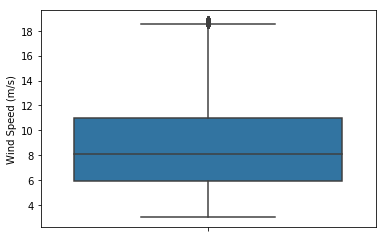

In [82]:
sb.boxplot(data = df, y= 'Wind Speed (m/s)')

##### 3.3 Separando em banco de dados de treinamento e teste

Os dados serão divididos em 80% treinamento e velidação e 20% para teste

In [83]:
train_lengh = int(len(df)*0.8)
train_data = df[0:train_lengh]

test_lengh = train_lengh + int(len(df)*0.2)
test_data = df[train_lengh:test_lengh]

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30922 entries, 0 to 40715
Data columns (total 5 columns):
Date/Time                        30922 non-null datetime64[ns]
LV ActivePower (kW)              30922 non-null float64
Wind Speed (m/s)                 30922 non-null float64
Theoretical_Power_Curve (KWh)    30922 non-null float64
Wind Direction (°)               30922 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7730 entries, 40716 to 50528
Data columns (total 5 columns):
Date/Time                        7730 non-null datetime64[ns]
LV ActivePower (kW)              7730 non-null float64
Wind Speed (m/s)                 7730 non-null float64
Theoretical_Power_Curve (KWh)    7730 non-null float64
Wind Direction (°)               7730 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 362.3 KB


#### 3.4 Escalonamento de dados de treinamento

In [84]:
dfn = train_data.copy()

i = ['LV ActivePower (kW)', 'Theoretical_Power_Curve (KWh)' ,'Wind Speed (m/s)', 'Wind Direction (°)']
for j in i:
    a = dfn[j].max()
    b = dfn[j].min()
    dfn[j] = (dfn[j]-b)/(a-b)
    
dfn.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,30922.000000,30922.000000,30922.000000,30922.000000
mean,0.442872,0.345646,0.489012,0.306788
std,0.344036,0.217616,0.362134,0.238094
min,0.000000,0.000000,0.000000,0.000000
25%,0.123243,0.173925,0.148538,0.131732
50%,0.362809,0.310413,0.411665,0.186010
75%,0.767142,0.493786,0.892512,0.542312
max,1.000000,1.000000,1.000000,1.000000


#### 3.5 Definindo features e targets

In [85]:
import numpy as np

features_train, targets_train = dfn[['Wind Speed (m/s)',"Wind Direction (°)"]], dfn['LV ActivePower (kW)']

# transformando em arrays

features_train = np.array(features_train)
targets_train = np.array(targets_train)

print(features_train.shape)
print(targets_train.shape)

(30922, 2)
(30922,)


### 4. Seleção do modelo

O modelo proposto em Schlechtingen e Santos (2011) é uma rede neural do tipo feedforward com 5 neurons na hidden layer, como mostrado na figura a seguir:

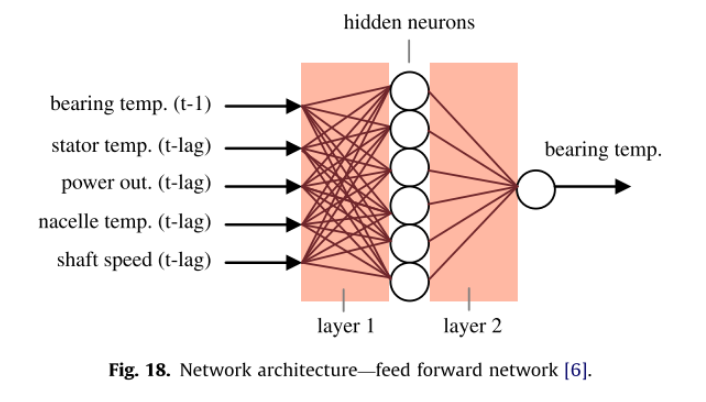

Os sinais de input, para o caso específico dessa simulação, serão Velocidade do Vento (Wind Speed) e Direção (Wind Direction), e a saída será a Potência de Saída (Power Output).

A função de ativação será a função Sigmoide.

Método de treinamento: Gradiente descendente com momento.

Pesos iniciados aleatóriamente.



In [86]:
# Importando keras

from keras.models import Sequential
from keras.layers import Dense

In [87]:
# definindo o modelo keras

model = Sequential()
model.add(Dense(5, input_dim = 2, activation = 'sigmoid'))
model.add(Dense(1, activation = 'linear'))

In [88]:
# compilando o modelo keras

model.compile(loss='mean_squared_error', optimizer = 'adam')

### 5. Treinando a rede neural

In [89]:
# fitting the model

X= features_train
y= targets_train

model.fit(X, y, epochs = 10, batch_size = 1)

Epoch 1/10
30922/30922 [==============================] - 23s 743us/step - loss: 0.0175
Epoch 2/10
30922/30922 [==============================] - 26s 827us/step - loss: 0.0088
Epoch 3/10
30922/30922 [==============================] - 23s 733us/step - loss: 0.0085
Epoch 4/10
30922/30922 [==============================] - 22s 708us/step - loss: 0.0079
Epoch 5/10
30922/30922 [==============================] - 22s 710us/step - loss: 0.0070
Epoch 6/10
30922/30922 [==============================] - 22s 711us/step - loss: 0.0058
Epoch 7/10
30922/30922 [==============================] - 22s 715us/step - loss: 0.0053
Epoch 8/10
30922/30922 [==============================] - 22s 706us/step - loss: 0.0051
Epoch 9/10
30922/30922 [==============================] - 22s 714us/step - loss: 0.0050
Epoch 10/10
30922/30922 [==============================] - 23s 734us/step - loss: 0.0049


In [90]:
# evaluating training loss

loss = model.evaluate(X, y)
print(loss)

30922/30922 [==============================] - 0s 15us/step
0.0049390074677125835


### 6. Teste da rede neural

In [91]:
# preparando os dados de teste

dfnt = test_data.copy()

i = ['LV ActivePower (kW)', 'Theoretical_Power_Curve (KWh)' ,'Wind Speed (m/s)', 'Wind Direction (°)']
for j in i:
    a = dfnt[j].max()
    b = dfnt[j].min()
    dfnt[j] = (dfnt[j]-b)/(a-b)
    
dfnt.describe()


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,7730.000000,7730.000000,7730.000000,7730.000000
mean,0.514433,0.396959,0.563208,0.353493
std,0.341845,0.220421,0.345846,0.240733
min,0.000000,0.000000,0.000000,0.000000
25%,0.196486,0.230061,0.238409,0.155190
50%,0.469711,0.358772,0.541098,0.238840
75%,0.866412,0.533542,0.948752,0.555681
max,1.000000,1.000000,1.000000,1.000000


In [92]:
# making predictions out of the test set

X_test = dfnt[['Wind Speed (m/s)','Wind Direction (°)']]
testing = model.predict(X_test)

testing = np.array(testing)
print(testing)
print(testing.shape)

[[0.2342705 ]
 [0.28072795]
 [0.2033909 ]
 ...
 [0.30309865]
 [0.45861724]
 [0.60304844]]
(7730, 1)


In [93]:
# evaluating test error

y_testing = np.array(dfnt['LV ActivePower (kW)']).reshape(-1, 1)
error = testing - y_testing


print(error)

[[-0.01501778]
 [ 0.00807851]
 [ 0.00298048]
 ...
 [-0.16418973]
 [-0.15203708]
 [-0.09488356]]


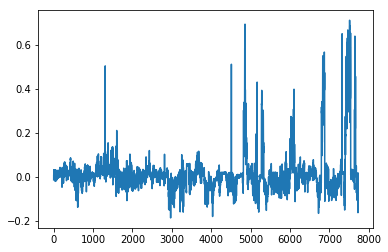

In [94]:
# plotting error

x = np.arange(1, len(y_testing)+1, 1)
y = error

plt.plot(x, y) 

### 7. Ajustes

In [95]:
df.corr()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
LV ActivePower (kW),1.000000,0.943495,0.973266,0.020504
Wind Speed (m/s),0.943495,1.000000,0.950241,0.036232
Theoretical_Power_Curve (KWh),0.973266,0.950241,1.000000,-0.008058
Wind Direction (°),0.020504,0.036232,-0.008058,1.000000


No quadro acima pode-se ver que a potência de saída tem uma correlação forte com a velocidade do vento, mas pequena em relação a direção do vento. Dessa forma, o modelo que leva em consideração a direção do vento não deve ter bons resultados. Dessa forma, vamos transformar a direção do vento em uma variável categórica. Essa variável será adicionada a rede neural mais adiante para testar seu desempenho com, e sem o one hot encoding.

In [119]:
wd_train = np.array(train_data['Wind Direction (°)'].copy())

for i in range(len(wd_train)):
    if wd_train[i] < 90:
        wd_train[i] = 1
    elif 90 <= wd_train[i] < 180:
        wd_train[i] = 2
    elif 180 <= wd_train[i] < 270:
        wd_train[i] = 3
    else:
        wd_train[i] = 4
        
wd_train = pd.DataFrame(wd_train.reshape(- 1, 1))
wd_train

,0
0,3.0
1,3.0
2,4.0
3,4.0
4,3.0
5,3.0
6,3.0
7,3.0
8,3.0
9,3.0


In [121]:
#utilizando one hot encoding

wd_dummies = pd.get_dummies(wd_train)
wd_dummies

,0
0,3.0
1,3.0
2,4.0
3,4.0
4,3.0
5,3.0
6,3.0
7,3.0
8,3.0
9,3.0
